### Credit card detection

Dataset description:

This description is already present in the dataset's page. But, for clarity purposes, I'll be highlighting the informations that are of interest to our work.
"The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, <b>where we have 492 frauds out of 284,807 transactions</b>. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. <b>Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.</b>"


Finally, they proceed to specify one of the most important facts in classifications metrics! If you noticed earlier, they mentioned that the dataset is highly unbalanced, "<b>Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC).</b> Confusion matrix accuracy is not meaningful for unbalanced classification.". If this isn't pure facts, I don't know what would be.

In [1]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token "kaggle.json"

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ------  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                     9KB  2022-10-06 08:55:25           7203        233  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset              11KB  2022-09-30 04:05:11           5808        187  1.0              
akshaydattatraykhare/car-details-dataset                        Car Details Dataset                                 56KB  2022-10-21 06:11:56           1512         32  1.0              
when

In [4]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:00<00:00, 94.2MB/s]
100% 66.0M/66.0M [00:00<00:00, 87.6MB/s]


In [5]:
!unzip creditcardfraud.zip
!mkdir data
!mkdir data/credit_card
!mv creditcard.csv data/credit_card/

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
%matplotlib inline
sns.set(rc = {'figure.figsize':(15,8)})

#ML Models
import tensorflow
from keras.models import Sequential
from keras.layers import Dense,Dropout
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
#Preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
#misc
import warnings
warnings.filterwarnings("ignore")


In [7]:
csv_path = "data/credit_card/creditcard.csv"
card_df = pd.read_csv(csv_path)
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
#Let's see if our dataset is squeaky clean!
card_df.isnull().sum()
#spoiler: it is o.o

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Let's jump into some EDA

In [9]:
card_df[['Amount']].describe()

,Amount
count,284807.000000
mean,88.349619
std,250.120109
min,0.000000
25%,5.600000
50%,22.000000
75%,77.165000
max,25691.160000


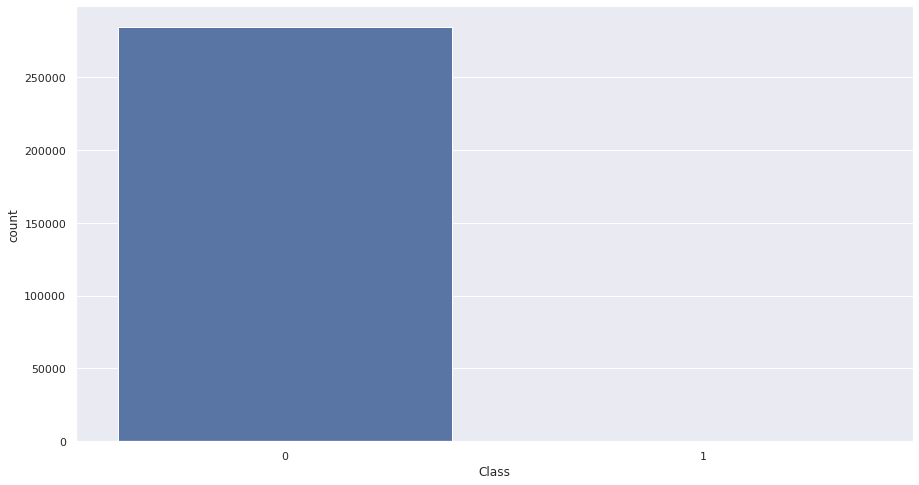

Number of fraudulant transactions:  492
Number of valid transactions:  284315


In [10]:
sns.countplot(card_df['Class']) #Let's get a visualization of our class repartitions
plt.show()

print('Number of fraudulant transactions: ',sum(card_df['Class']==1))
print('Number of valid transactions: ',sum(card_df['Class']==0))

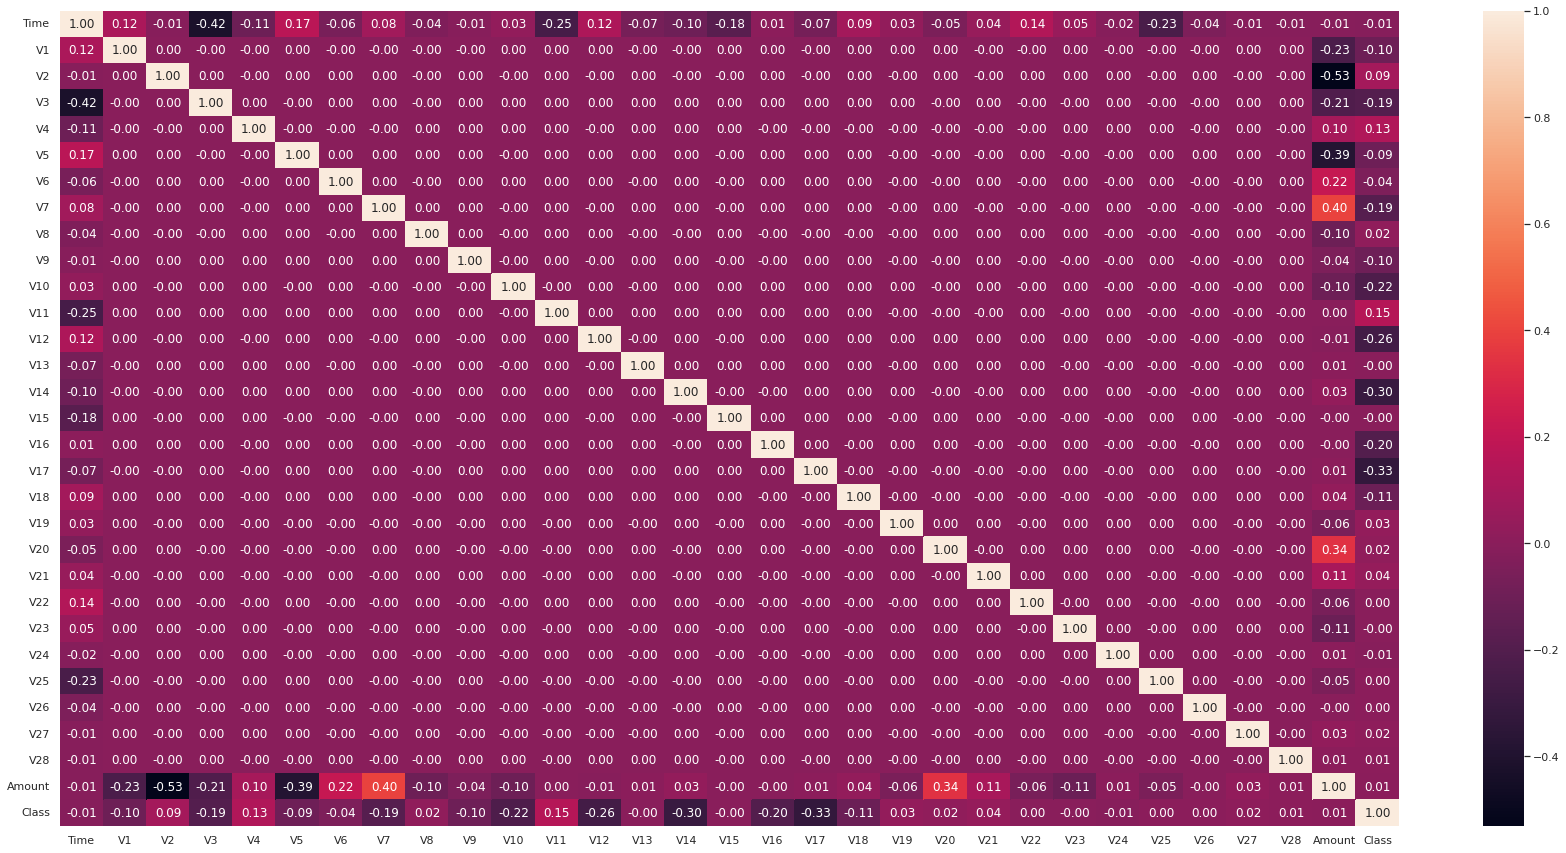

In [11]:

corr = card_df.corr()
plt.figure(figsize=(30,15))
sns.heatmap(corr,annot=True,fmt='.2f')
plt.show()

high_corr_columns = ['V7','V10','V11','V12','V14','V16','V17']

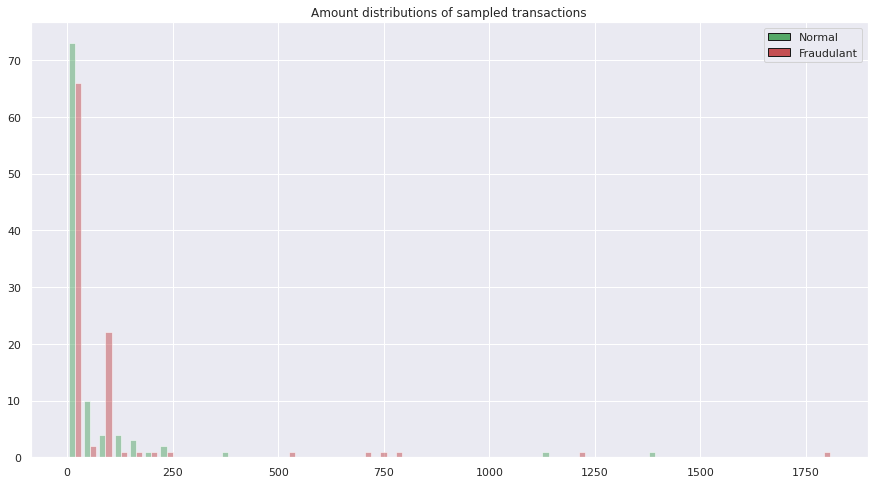

In [12]:
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['g','r']]
labels= ["Normal",'Fraudulant']

class_0 = card_df[card_df['Class'] == 0][:100]
class_1 = card_df[card_df['Class'] == 1][:100]
plt.hist([class_0['Amount'],class_1['Amount']], color=['g','r'], alpha=0.5,bins=50)
plt.legend(handles, labels)
plt.title('Amount distributions of sampled transactions')
plt.show()

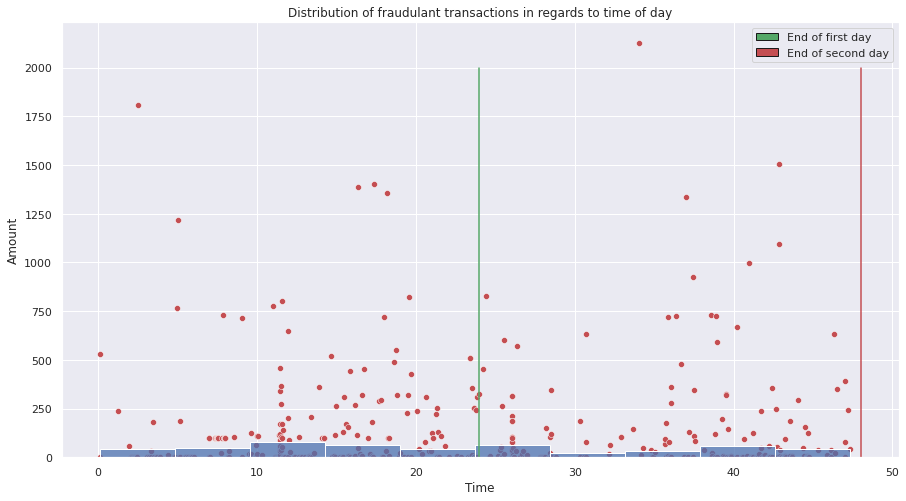

In [13]:
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['g','r']]
labels= ["End of first day",'End of second day']
frauds = card_df[card_df['Class'] == 1]
frauds['Time'] = frauds['Time']/60/60 #we devide by 60*60 to get the hours in the axis.
sns.scatterplot(data=frauds,x='Time',y='Amount',color='r')
sns.histplot(frauds['Time'])
plt.plot([86400/60/60, 86400/60/60], [0, 2000],color='g')#End of first day
plt.plot([(86400*2-1)/60/60, (86400*2-1)/60/60], [0, 2000],color='r') #end of second day
plt.legend(handles,labels)
plt.title('Distribution of fraudulant transactions in regards to time of day')
plt.show()

### Data preparing and model training

In [14]:
y = card_df['Class']
x = card_df.drop(['Time','Class'],axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, stratify=y)
X_train.shape

(199364, 29)

In [16]:
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train.Amount.values.reshape(-1,1))
X_test['Amount'] = scaler.transform(X_test.Amount.values.reshape(-1,1))

In [17]:
X_train,y_train = SMOTE().fit_resample(X_train,y_train) #Generate new fraudulant transactions based on the existing ones.
y_train.value_counts()

0    199020
1    199020
Name: Class, dtype: int64

In [18]:
"""
### GRID SEARCH CODE FOR RANDOMFOREST MODEL###
rf_params = {
 'max_depth': [5,10,None],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50,100]}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = rf_params,cv=3, verbose=2, n_jobs = -1,refit=True)
best_rf = rf_grid.fit(X_train,y_train)

rf_preds = best_rf.predict(X_test)
acc_rf,precision_rf,recall_rf = accuracy_score(y_test, rf_preds),precision_score(y_test,rf_preds),recall_score(y_test,rf_preds)
"""
rf = RandomForestClassifier(max_depth=10,n_estimators=100)

rf.fit(X_train,y_train)

rf_preds = rf.predict(X_test)

acc_rf,precision_rf,recall_rf = accuracy_score(y_test, rf_preds),precision_score(y_test,rf_preds),recall_score(y_test,rf_preds)

In [19]:
"""
### GRID SEARCH CODE FOR XGBOOST MODEL###
xg_params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [ 0.8, 1.0],
        'max_depth': [3, 5]
        }

xg = xgboost.XGBClassifier()
xg_grid = GridSearchCV(estimator = xg, param_grid= xg_params,cv=3, verbose=2, n_jobs = -1,refit=True)
best_xg = xg_grid.fit(X_train,y_train)

xg_preds = best_xg.predict(X_test)
acc_xg,precision_xg,recall_xg = accuracy_score(y_test, xg_preds),precision_score(y_test,xg_preds),recall_score(y_test,xg_preds)
"""


xg = xgboost.XGBClassifier()
xg.fit(X_train,y_train)

xg_preds = xg.predict(X_test)

acc_xg,precision_xg,recall_xg = accuracy_score(y_test, xg_preds),precision_score(y_test,xg_preds),recall_score(y_test,xg_preds)

In [20]:
print("Accuracy RandomForest vs XGBoost: {:.5f}%  vs {:.5f}%".format(acc_rf,acc_xg))
print("precision RandomForest vs XGBoost: {:.2f}%  vs {:.2f}%".format(precision_rf,precision_xg))
print("Recall RandomForest vs XGBoost: {:.2f}%  vs {:.2f}%".format(recall_rf,recall_xg))


Accuracy RandomForest vs XGBoost: 0.99854%  vs 0.98984%
precision RandomForest vs XGBoost: 0.55%  vs 0.14%
Recall RandomForest vs XGBoost: 0.85%  vs 0.92%


In [21]:

rf_preds_prob = rf.predict_proba(X_test)[:,1]
xg_preds_prob = xg.predict_proba(X_test)[:,1]
auc_xg = roc_auc_score(y_test,xg_preds_prob)
auc_rf = roc_auc_score(y_test,rf_preds_prob)
print("AUC score RandomForest vs XGBoost: {:.5f}%  vs {:.5f}%".format(auc_rf,auc_xg))

AUC score RandomForest vs XGBoost: 0.98045%  vs 0.97915%
